<h2>Matrix factorization - the MAP inference algorithm</h2>
<p> Implement with a movie rating dataset. 100,000 ratings (1-5) from 943 users on 1682 movies.</p>
<p> assumption: u,v ~ normal</p>

In [379]:
import pandas as pd
import numpy as np
PATH=
train = pd.read_csv(PATH+"/ratings.csv",header=None)
test = pd.read_csv(PATH+"/ratings_test.csv",header=None)
train.columns=['user_id','movie_id','ratings']
test.columns=['user_id','movie_id','ratings']
#train.describe()
n_movie = 1682
n_user = 943
n_test=len(test)

In [397]:
train_mij = pd.DataFrame(columns=list(range(1,n_movie+1)),index=list(range(1,n_user+1)))
test_mij = pd.DataFrame(columns=list(range(1,n_movie+1)),index=list(range(1,n_user+1)))

for i in range(0,len(train)):
    train_mij.loc[int(train.loc[i,:][0]),int(train.loc[i,:][1])] = train.loc[i,:][2]

for i in range(0,len(test)):
    test_mij.loc[int(test.loc[i,:][0]),int(test.loc[i,:][1])] = test.loc[i,:][2]
    
train_mij = train_mij.fillna(np.nan)    
test_mij = test_mij.fillna(np.nan)
train_mij = np.matrix(train_mij)
test_mij = np.matrix(test_mij)

In [380]:
def error_cal(u,v,truth=train_mij):
    return (np.square(np.multiply(u*v,(~np.isnan(truth))) - np.nan_to_num(truth))).sum()


In [402]:
objective_10 = dict()
sigma_sq = 0.25
lam = 1
d = 10
inden_matrix=lam*sigma_sq*np.identity(d)
objective_RMSE={'RMSE':[],'Objective_value':[]}
save_result = {}

#update ui
for t in range(1,11):
    V = np.matrix(np.random.multivariate_normal(np.repeat(0,d),np.identity(d)/lam,(n_movie)).T )#ASSUME
    U = np.matrix(np.repeat(np.nan,n_user*d).reshape(n_user, d))
    objective = []
    for loop in range(100):
        for i in range(0,n_user):
            had = np.array(~np.isnan(train_mij[i,:]))[0]
            vj = V[:,had]
            mij = train_mij[i,had]
            U[i,:] = (((inden_matrix + vj*vj.T).I)*(vj*mij.T)).T


        for j in range(0,n_movie):
            had = np.array(~np.isnan(train_mij[:,j].T))[0]
            uj = U[had,:]
            mij = train_mij[had,j]
            V[:,j] = (((inden_matrix + uj.T*uj).I)*(uj.T*mij))
            
        if loop >=2:
            L = -1*error_cal(U,V)/(2*sigma_sq) - np.square(V).sum()*lam/2 - np.square(U).sum()*lam/2
            objective.append(L)
            
    RMSE = np.sqrt(error_cal(U,V,test_mij)/n_test)
    objective_RMSE['RMSE'].append(RMSE)
    objective_RMSE['Objective_value'].append(L)
    objective_10[str(t)]=objective
    save_result[str(t)] = [U,V]

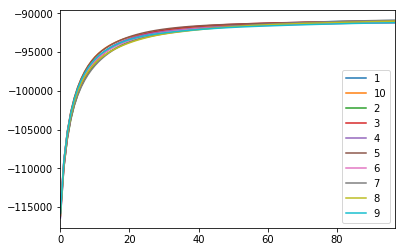

In [432]:
from matplotlib import pyplot as plt
%matplotlib inline
pd.DataFrame(objective_10).plot() #Objective value change per iteration with 10 runs.

In [487]:
object_RMSE_df = pd.DataFrame(objective_RMSE)
object_RMSE_df.index=list(range(1,11))
object_RMSE_df = object_RMSE_df.sort_values(by='Objective_value',axis=0,ascending=False)
object_RMSE_df #final objective value and RMSE for each run sorted by objective values.

,Objective_value,RMSE
7,-90884.510866,1.071046
1,-90916.448659,1.107513
10,-90967.103133,1.116390
3,-90998.605180,1.163461
8,-91002.610699,1.089633
5,-91090.997120,1.109342
2,-91162.131517,1.174233
6,-91169.882827,1.136901
9,-91199.892054,1.107410
4,-91214.845716,1.103432


In [488]:
#movie list
f = open(PATH+"/movies.txt","r",encoding="utf-8")
movie_list = []
for movie in f:movie_list.append(movie)

for i in range(len(movie_list)):
    movie_list[i] = movie_list[i].replace('\n','')
    

def match_name(name,movie_list=movie_list):
    index = 0
    for i in movie_list:
        if name in i:return index+1
        else: index += 1
            
def match_id(index,movie_list=movie_list):
    return movie_list[index-1]
 

In [489]:
def cal_dist(target_num,v):
    target = v[:,target_num]
    dist = {}
    return_dict=[]
    for i in range(len(v.T)):
        dist[i] = np.square(target-v[:,i]).sum()
        
    sort_dist = sorted(dist,key=lambda x:dist[x])[1:11]
    
    for i in sort_dist:
        return_dict.append([i,dist[i]])
        
    return return_dict

In [491]:
highest_result = object_RMSE_df.index[0]
nearest_movies = {match_id(match_name("Star Wars")):[],match_id(match_name("My Fair Lady")):[],match_id(match_name("GoodFellas")):[]}
for i in [match_name("Star Wars") ,match_name("My Fair Lady"),match_name("GoodFellas")]:
    closest_list = cal_dist(i,save_result[str(highest_result)][1])
    for each in closest_list:
        each.append(match_id(each[0]))
    index_list =[]
    movie_dict={'movie_name':[],'distance':[]}
    for a,b,c in closest_list:
        index_list.append(a)
        movie_dict['movie_name'].append(c)
        movie_dict['distance'].append(b)
    
    movie_df = pd.DataFrame(movie_dict)
    movie_df.index = index_list
    movie_df.to_csv(str(match_id(i))+'.csv')

In [492]:
movie_df #10 movies closest to GoodFellas (1990) sorted by distance index

,distance,movie_name
522,0.251305,Down by Law (1986)
176,0.292127,Aliens (1986)
493,0.378493,"Thin Man, The (1934)"
175,0.403023,Brazil (1985)
519,0.472812,"Treasure of the Sierra Madre, The (1948)"
187,0.488497,"Godfather: Part II, The (1974)"
194,0.514554,"Sting, The (1973)"
490,0.586187,To Catch a Thief (1955)
198,0.612037,Nikita (La Femme Nikita) (1990)
529,0.613534,My Life as a Dog (Mitt liv som hund) (1985)
